In [56]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [57]:
#hide
from fastbook import *

In [58]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

# 파스칼 2007 데이터셋을 path 로 지정

In [59]:
df = pd.read_csv(path/'train.csv')
#df.head() # 상위 다섯 개의 행만 출력해줌

# Pandas

테이블 데이터와 시계열 데이터를 분석하고 조작하는데 특화된 파이썬 라이브러리다.

데이터프레임은 행과 열로 구성된 테이블을 표현하는 능력이 있는데, \
csv 뿐만 아니라 database table, python dictionary 도 전부 데이터프레임으로 \
표현이 가능하다.

iloc(index location)으로 인덱싱도 가능하다.

In [60]:
df.iloc[:,0]
# 1열인 파일 네임을 모든 행에 해당되게 인덱싱함

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [61]:
df.iloc[0, :]
# 1행의 데이터를 모두 가져옴

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [62]:
df['labels'] # 열 이름으로 색인할 수 있다. = df.iloc[1]

0                chair
1                  car
2         horse person
3                  car
4              bicycle
             ...      
5006      horse person
5007              boat
5008    person bicycle
5009               car
5010               dog
Name: labels, Length: 5011, dtype: object

In [63]:
# 새로운 열을 만들고 계산도 가능하다.

df1 = pd.DataFrame()
df1['a'] = [1,2,3,4]
df1

,a
0,1
1,2
2,3
3,4


In [64]:
df1['b'] = [23,41,33,2]
df1['a'] + df1['b']

0    24
1    43
2    36
3     6
dtype: int64

# Setup Datablock

단계적으로 구축해야 한다.

* Dataset \
 : 단일 데이터를 표현하는 독립변수 및 종속변수의 튜플을 반환한다.
* DataLoader \
 : 미니배치 스트림을 제공하는 반복자로, 각 미니배치는 여러 독립변수와 종속변수에 \ 
 대한 튜플로 구성된다.

뒤에 s 가 붙으면 학습용, 검증용 Dataset or DataLoader가 포함된 반복자 및 객체다

In [65]:
# 빈 영역의 데이터블록을 생성 클래스의 형식이다.
dblock = DataBlock()

In [66]:
# dblock에 데이터셋을 넘기기
dsets = dblock.datasets(df) # 모든 데이터를 통째로 넘겨준다.

dsets.valid[0] # 똑같은 객체를 두번 반환한다.
# 기본적으로 데이터블럭은 입력과 타깃 두 요소가 온다고 가정하기 때문이다.

(fname       005416.jpg
 labels             dog
 is_valid          True
 Name: 2718, dtype: object, fname       005416.jpg
 labels             dog
 is_valid          True
 Name: 2718, dtype: object)

In [67]:
dblock = DataBlock(get_x= lambda r : r['fname'], get_y= lambda r : r['labels']) # 여기서 r은 데이터셋의 인덱스로 도출된 데이터를 의미한다.

dsets = dblock.datasets(df)
dsets.train[0] # ('002549.jpg', 'tvmonitor')

('009116.jpg', 'car')

In [68]:
# 람다 말고 그냥 함수 쓰자..

def get_x(r): return path/'train'/r['fname'] # r이 진짜 뭐지?
def get_y(r): return r['labels'].split(' ') # 공백을 기준으로 나눠서 리스트로 반환
dblock = DataBlock(get_x= get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/009091.jpg'), ['person'])

In [69]:
# 이미지를 가져올 땐 ImageBlock을 사용해도 좋지만 CategoryBlock은 단일 정수만을 반환하기 때문에 여러 범주에 관한 다른 카테고리 테이블이 있어야 한다.
# 그게 바로 MultiCategoryBlock이다.

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

# (PILImage mode=RGB size=500x333,
# TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

# blocks에 맞게 적절하게 반환이 되었고 멀티카테고리는 0, 1의 숫자로 나열되는데 이는 
# 벡터가 나열되는데 그 벡터 중 데이터가 해당되는 카테고리의 값을 1로 반환해준다.
# 위와같은 표현방식을 one-hot encoding 이라 한다.

(PILImage mode=RGB size=431x500,
 TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [70]:
dsets.train[0][1] == 1. # False , False , True , False..
idxs = torch.where(dsets.train[0][1] == 1.)[0] # 1과 일치한 값을 반환하는데 여러개면 튜플을 반환함
idxs # TensorMultiCategory([2]) 벡터 내의 인덱스

dsets.train.vocab[idxs] # ['bird']
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [71]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()

In [72]:
train = df.index[~df['is_valid']]
~df['is_valid'] # 유효하면 True , 아니면 False 그러나 ~ 는 결과 역전임

train , ~df['is_valid']

# True만 가진 값들의 인덱스를 뽑아낸다. 총 데이터 셋에서 ~df['is_valid'] 가 True 인 데이터셋은 2501개 

(Int64Index([   3,    5,    9,   11,   13,   14,   15,   16,   17,   20,
             ...
             4991, 4993, 4996, 4998, 4999, 5000, 5001, 5004, 5009, 5010],
            dtype='int64', length=2501), 0       False
 1       False
 2       False
 3        True
 4       False
         ...  
 5006    False
 5007    False
 5008    False
 5009     True
 5010     True
 Name: is_valid, Length: 5011, dtype: bool)

In [73]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist() # 인덱스를 모두 리스트로 전환함
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [74]:
# DataLoaders를 통해 모든 데이터의 크기 통일화

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale = 0.35))
dls = dblock.dataloaders(df)

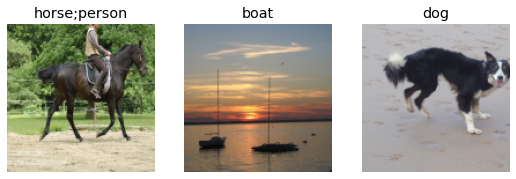

In [75]:
dls.show_batch(nrows=1, ncols=3)

In [76]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

# Binary cross entropy

In [77]:
learn = vision_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

# x는 독립변수 y는 종속변수(레이블) 이다.
# 행은 각 이미지 텐서고, 열은 카테고리의 vocab 갯수다.

torch.Size([64, 20])

In [79]:
activs[0] # 첫 행 그러니까 배치 안에 들어있는 이미지 텐서 하나에서 모델을 통해 예측한 vocab의 확률 

TensorBase([-4.0412, -1.3334, -2.3237, -2.9404,  1.3875,  1.4053,  0.6759, -2.0999, -1.5656, -1.9857, -1.2084, -1.9695, -0.2615,  2.1374, -0.8206,  1.3310, -1.9808,  0.1913,  0.0524,  3.0180],
           grad_fn=<AliasBackward0>)

In [80]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid() # 위의 확률 값을 시그모이드로 조정함
  return -torch.where(targets==1, 1-inputs, inputs).log().mean() # 값을 선별하고, 만약 같다면 1에서 빼어 내 0과 가까운 손실함수를 구성하고, 로그를 씌운 뒤, 각 값에 대한 평균값을 구한다.
  # 그리고 마이너스는 뭐지? 지수로그 쓰면 1이하의 값은 모두 음수가 되기 때문에 마이너스를 붙여야 한다.

# softmax는 모든 확률의 합이 1이기 때문에 다중 레이블 문제에서는 사용되기 어려움
# nll_lose도 단일 레이블에 대응하는 값 하나만 반환하기 때문에 의미없는 손실이다. 

In [81]:
# 기존에 이진 교차 엔트로피 함수가 있으나 (nn.BCELoss, F.binary_cross_entropy), 초기에 시그모이드를 적용하지 않음
# 시그모이드를 적용하는 F.binary_cross_entropy_with_logits 또는 nn.BCEWithLogitLoss를 사용한다.

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
# TensorMultiCategory(1.0164, grad_fn=<AliasBackward0>)

loss1 = binary_cross_entropy(activs, y)
# TensorMultiCategory(1.0888, grad_fn=<AliasBackward0>) # 마이너스 없애고
loss1

# 자연로그 함수라서 1 이하의 값은 전부 음수로 되니까 마이너스를 붙인 게 아닐까?


# 따로 지정할 필요가 없는 게 자동으로 fastai는 손실함수를 자동으로 찾아내서 사용한다.

TensorMultiCategory(1.0780, grad_fn=<AliasBackward0>)

In [82]:
# argmax는 가장 높은 출력의 활성 단 하나만 반환한다.
# 예를 들어 다중 레이블이 존재하는 사진에서 세 개의 높은 값을 지닌 활성을 가졌다면
# [0.4, 0.89, 0.96, 0.75, 0.31] 여기서 높은 3개의 index 1,2,3 값 중 단 하나 0.96만 반환한다.

# 그래서 다중 레이블의 출력 레이블은 0~1에서 임계점threshold를 잡아줘야 한다. 임계점을 넘으면 1, 그렇지 않으면 0을 반환한다.

def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "'input'과 'targ'의 크기가 같을 때 정확도를 계산한다."
  if sigmoid: inp = inp.sigmoid() # 인풋의 값을 시그모이드로 전환
  return ((inp > thresh) == targ.bool()).float().mean() # 임계점을 넘으면 True로 반환하고 타겟도 역시 불리언으로 바꿔 동일하면 True, 아니면 False,
  # 다시 부동소수점으로 바꾸고 평균을 구한다

# partial

기존의 함수 기본 값에서 조정하여 고정하도록 하는 새로운 함수를 생성할 때 사용
functools에 내장된 함수다

In [83]:
def say_hello(name, msg='hello'): return f"{name}, {msg}"
say_hello('beom')
# 'beom, hello' 

f = partial(say_hello, msg='bye')
f('beom')

'beom, bye'

In [84]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr = 3e-3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.940352,0.689280,0.230398,00:41
1,0.821160,0.558126,0.289900,00:29
2,0.603466,0.202794,0.820518,00:29
3,0.360673,0.122396,0.942430,00:33


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133705,0.114956,0.943526,00:30
1,0.117556,0.107993,0.949582,00:30
2,0.097555,0.102988,0.952829,00:32


In [85]:
# 임계점이 너무 낮을 때
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10298822075128555,0.9343624711036682]

In [86]:
# 임계점이 너무 높을 때
learn.metrics = partial(accuracy_multi, thresh=0.9)
learn.validate()

(#2) [0.10298822075128555,0.9567329287528992]

In [87]:
preds, targs = learn.get_preds()

preds, targs # preds는 이미 시그모이드가 적용됐다.

(TensorBase([[3.7950e-04, 5.0601e-03, 1.7985e-03,  ..., 2.2005e-01, 9.4232e-04, 7.3015e-02],
             [1.2893e-04, 9.7282e-03, 1.1595e-03,  ..., 4.0017e-03, 6.3760e-04, 1.1836e-04],
             [1.9792e-03, 2.2415e-02, 5.0265e-03,  ..., 9.5803e-04, 6.2804e-04, 8.1086e-04],
             ...,
             [2.2224e-03, 1.3238e-03, 4.5860e-04,  ..., 5.7846e-03, 2.1574e-03, 1.3286e-02],
             [1.8643e-02, 1.9250e-03, 1.2228e-02,  ..., 1.6820e-03, 2.8323e-02, 3.1033e-03],
             [2.2489e-03, 9.3134e-01, 4.4183e-03,  ..., 6.0112e-03, 1.2311e-03, 7.3217e-03]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]))

In [89]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

# 최적의 임계점 찾기

TensorBase(0.9567)

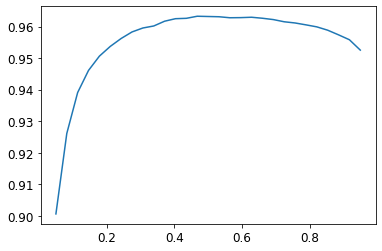

In [90]:
# 임계점마다 변화하는 정확도를 그래프로

xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh = i, sigmoid=False) for i in xs]
plt.plot(xs, accs)